In [1]:
# step size
# Makes report plot
# improt and define basic params
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs
sns.set(style="darkgrid")
%matplotlib inline

mpl.rcParams["savefig.dpi"] = 200
# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
uncalibrated_base_dir = Path("..")/"../uncalibrated_data/"
calibration_curve_base_dir = Path("..")/"../calibration_curve/"
calibrated_table_dir = Path("..")/"../tables/"
uncalibrated_table_dir = Path("..")/"../uncalibrated_tables/"

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

In [2]:
legend_order = ['bravo    | p=0.7 ',
                'bravo    | p=0.55 ',
                'bravo    | p=0.52 ',
                'bravo    | p=0.51 ',
                'bravo_without_replacement | p=0.7 ',
                'bravo_without_replacement | p=0.55 ',
                'bravo_without_replacement | p=0.52 ',
                'bravo_without_replacement | p=0.51 ',
                'bayesian | a=1 | b=1 ',
                'bayesian_with_replacement | a=1 | b=1 ',
                'truncated_bayesian | a=1 | b=1 ',
                'clip     ', 
                'max_sprt ']

def get_position(name):
    for i, legend_pattern in enumerate(legend_order):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        assert False

def reorder_df(df):
    return df.loc[sorted(df.index, key=get_position)]

mpl.rcParams["figure.figsize"] = [8, 6]

def read_csv(file_path, reorder=True):
    df = pd.read_csv(file_path)
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.set_index('legend', inplace=True)
    if reorder:
        df = reorder_df(df)
    return df.reset_index()

def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def format_legend(ax=None, legend=None, how=0):
    if ax is not None:
        legend_ = ax.legend_
    elif legend is not None:
        legend_ = legend
    else:
        return
    
    for text in legend_.texts:
        if how == 0:
            raw = text.get_text()
            text.set_text(raw.replace(" | ", ", ").replace(" ", "").rsplit(",", 1)[0])
        elif how == 1:
            raw = text.get_text()
            print(raw.rsplit(",", 1)[0].replace("_", " "))
            text.set_text(raw.rsplit(",", 1)[0].replace("_", " "))
    return legend_

def make_legend(df, ax, outside=False, *args, **kwargs):
    if outside:
        ax.legend(labels=[basename+" "+parameter+" "+"batch={}".format(step) for i, (basename, parameter, step) in 
                          df[['basename_with_type', 'parameter', 'election_step']].drop_duplicates()
                          .iterrows()],
                 bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 *args, **kwargs)
    else:
        ax.legend(labels=[basename+" "+parameter+" "+"batch={}".format(step) for i, (basename, parameter, step) in 
                          df[['basename_with_type', 'parameter', 'election_step']].drop_duplicates()
                          .iterrows()], *args, **kwargs)

In [3]:
cols = sns.color_palette("bright", 6)
cs_dict = {'bayesian | a=1 | b=1':cols[0],
           'bayesian_with_replacement | a=1 | b=1':cols[0],
           'bravo    | p=0.55':cols[1],
           'bravo    | p=0.7':cols[1],
           'bravo_without_replacement | p=0.55':cols[2],
           'bravo_without_replacement | p=0.7':cols[2],
           'clip    ':cols[3], 
           'max_sprt':cols[4],
           'truncated_bayesian | a=1 | b=1':cols[5]}

# ls_dict = {'bayesian | a=1 | b=1':'-',
#            'bayesian_with_replacement | a=1 | b=1':'--',
#            'bravo    | p=0.55':'-',
#            'bravo    | p=0.7':'--',
#            'bravo_without_replacement | p=0.55':'-',
#            'bravo_without_replacement | p=0.7':'--',
#            'clip    ':'--', 
#            'max_sprt':'--',
#            'truncated_bayesian | a=1 | b=1':'--'}
ls_dict = {'bayesian | a=1 | b=1':'-',
           'bayesian_with_replacement | a=1 | b=1':'-',
           'bravo    | p=0.55':'-',
           'bravo    | p=0.7':'-',
           'bravo_without_replacement | p=0.55':'-',
           'bravo_without_replacement | p=0.7':'-',
           'clip    ':'-', 
           'max_sprt':'-',
           'truncated_bayesian | a=1 | b=1':'-'}

ms_dict = {'bayesian | a=1 | b=1':'o',
           'bayesian_with_replacement | a=1 | b=1':'s',
           'bravo    | p=0.55':'<',
           'bravo    | p=0.7':'>',
           'bravo_without_replacement | p=0.55':'P',
           'bravo_without_replacement | p=0.7':'X',
           'clip    ':'o', 
           'max_sprt':'o',
           'truncated_bayesian | a=1 | b=1':'o'}

In [4]:
def map_styles(legends):
    cs, ls, ms = [], [], []
    for legend in legends:
        legend = legend.rsplit(" | ", 1)[0]
        ls.append(ls_dict[legend])
        cs.append(cs_dict[legend])
        ms.append(ms_dict[legend])
    return cs, ls, ms

In [5]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'MartInf',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'BetaBinomial',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (BetaBinomial)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAudit',
                          'bravo_without_replacement ': 'BRAVO (Hypergeometric)',
                          'truncated_bayesian ': 'MartInf',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

filled_markers = (
    'o', 'v', '^', 
    
    '<', '>', '*', 
    
    's', '8', 
    
    'H', 
    
    'D', 
    
    'X')
dash_styles = [
    "",
    (4, 1.5),
    (1, 1),
    (1, 2.5, 3, 1.2),
    (5, 1, 2, 1, 2, 1),
    "",
    (4, 1.5),
    (1, 1),
    (1, 2.5, 3, 1.2),
    (5, 1, 2, 1, 2, 1),
]

In [6]:
def prep_long_df(df):
    if 'legend' not in df.columns:
        df = df.reset_index()
    data_long = pivot_widetable(df, [], [], id_vars='legend', var_name='p')
    types = data_long.legend.apply(group_type)
    basenames = data_long.legend.apply(group_basename)
    parameters = data_long.legend.apply(group_parameter)
    basenames_with_type = data_long.legend.apply(group_basename_with_type)
    parameters_with_type = data_long.legend.apply(group_parameter_with_type)
    data_long['type'] = types
    data_long['basename'] = basenames
    data_long['basename_with_type'] = basenames_with_type
    data_long['parameter'] = parameters
    data_long['parameter_with_type'] = parameters_with_type
    data_long['fullname'] = basenames_with_type + ' ' + parameters
    return data_long

In [7]:
def get_data(elections, data_type, query='(basename=="BRAVO" and parameter=="p=0.55" and type=="Hypergeometric") or'
                                                  '(basename=="Bayesian" and type=="BetaBinomial")'):
    all_data_long_dict = {}
    for election in elections:
        data_path = calibrated_table_dir/str(election)/data_type
        data_long = prep_long_df(read_csv(data_path))
        all_data_long_dict[election] = data_long

    _filtered_data_long = []
    for election in all_data_long_dict:
        data = all_data_long_dict[election].query(query)
        data.loc[:, 'election_n'] = election.n
        data.loc[:, 'election_m'] = election.m
        data.loc[:, 'election_replacement'] = election.replacement
        data.loc[:, 'election_step'] = election.step
        _filtered_data_long.append(data)
    filtered_data_long = pd.concat(_filtered_data_long, ignore_index=True)
    filtered_data_long = reorder_df(filtered_data_long.set_index('legend')).reset_index()
    return filtered_data_long

/Users/Dovermore/.conda/envs/audit_analysis/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Dovermore/.conda/envs/audit_analysis/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Text(0, 0.5, 'Power')

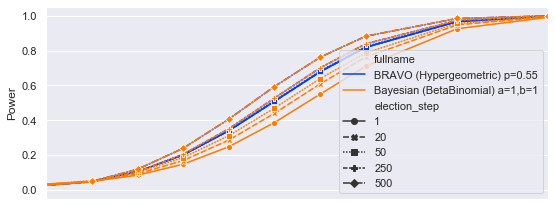

In [8]:
fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
elections = [Election(5000, 500, 0.5, s) for s in [1, 20, 50, 250, 500]]
data_type = "power.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    style= 'election_step',
    data = data,
    markers=True, 
    palette='bright', 
    legend='full', 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlim(0.49, 0.6)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")

In [9]:
ax.legend_.texts

[Text(0, 0, 'fullname'),
 Text(0, 0, 'BRAVO (Hypergeometric) p=0.55'),
 Text(0, 0, 'Bayesian (BetaBinomial) a=1,b=1'),
 Text(0, 0, 'election_step'),
 Text(0, 0, '1'),
 Text(0, 0, '20'),
 Text(0, 0, '50'),
 Text(0, 0, '250'),
 Text(0, 0, '500')]

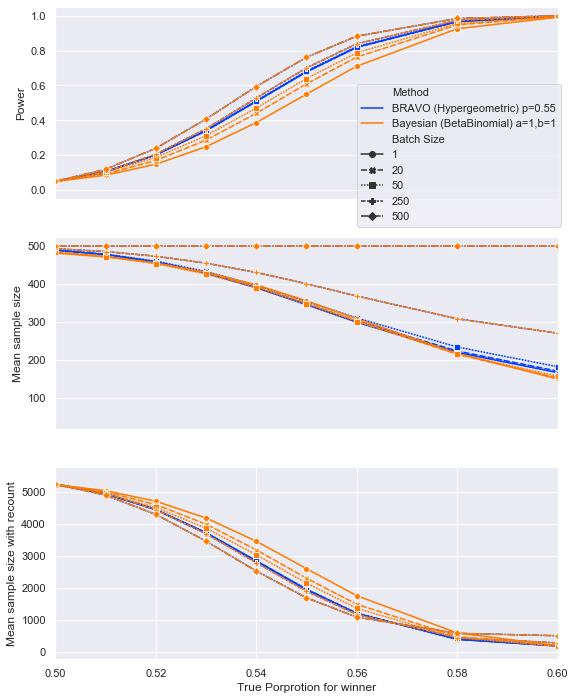

In [10]:
# 1. Basic 5000/500 plot without replacement

fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
elections = [Election(5000, 500, 0.5, s) for s in [1, 20, 50, 250, 500]]
data_type = "power.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    style= 'election_step',
    data = data,
    markers=True, 
    palette='bright', 
    legend='full', 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlim(0.5, 0.6)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")

# plt.legend(title='method', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
plt.legend(bbox_to_anchor=(0.6, 0.6), borderaxespad=0.)
ax.legend_.texts[0].set_text('Method')
ax.legend_.texts[3].set_text('Batch Size')
# make_legend(data, ax, bbox_to_anchor=(0.5, 0.35), loc=2, borderaxespad=0.)

ax = fig.add_subplot(312)
data_type = "unconditional_mean.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    style= 'election_step',
    data=data,
    markers=True, 
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlim(0.5, 0.6)
ax.xaxis.set_visible(False)
ax.set_ylabel("Mean sample size")

ax.set_zorder(-1)

ax = fig.add_subplot(313)
data_type = "unconditional_mean_with_recount.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    style= 'election_step',
    data=data,
    markers=True, 
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlim(0.5, 0.6)
ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Mean sample size with recount")


ax.set_zorder(-1)

plt.savefig('../../figures/step_roc_5000.png')

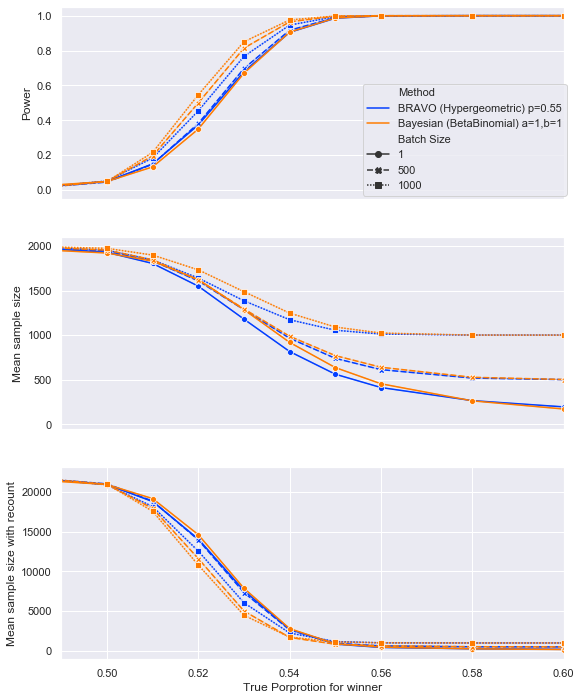

In [11]:
# 1. Basic 20000/2000 plot without replacement

fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
elections = [Election(20000, 2000, 0.5, s) for s in [1, 500, 1000]]
data_type = "power.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    style= 'election_step',
    data=data,
    markers=True, 
    palette='bright', 
    legend='full', 
#     sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlim(0.49, 0.6)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")

plt.legend(bbox_to_anchor=(0.6, 0.6), borderaxespad=0.)
ax.legend_.texts[0].set_text('Method')
ax.legend_.texts[3].set_text('Batch Size')

ax = fig.add_subplot(312)
data_type = "unconditional_mean.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    style= 'election_step',
    data=data,
    markers=True, 
    palette='bright', 
    legend=False, 
#     sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlim(0.49, 0.6)
ax.xaxis.set_visible(False)
ax.set_ylabel("Mean sample size")

ax.set_zorder(-1)

ax = fig.add_subplot(313)
data_type = "unconditional_mean_with_recount.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    style= 'election_step',
    data=data,
    markers=True, 
    palette='bright', 
    legend=False, 
    ax=ax)
ax.set_xlim(0.49, 0.6)
ax.set_xlabel("True Porprotion for winner")
ax.set_ylabel("Mean sample size with recount")

ax.set_zorder(-1)

plt.savefig('../../figures/step_roc_20000.png')